#### AWS

Include the analysis script and setup the folders with raw data

We used a 10G connection instance 

Zone: eu-west-1a, instance type p3.2xlarge = 

- 1	GPUs - Tesla V100
- N/A	GPU Peer to Peer
- 16	GPU Memory (GB)
- 8	vCPUs
- 61	Memory (GB)
- Up to 10 Gbps Network Bandwidth	
- 1.5 Gbps EBS Bandwidth


boto3 endpoint = http://s3.amazonaws.com

In [1]:
from benchmarking.analysis.analyze_results import *

In [2]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking-raw/referenced-experiments/aws")
s3_folder_filter="aws_long_1/*benchmark_e2e*"

#### Load raw data

In [3]:
df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [00:12<00:00, 174.44it/s]


In [4]:
# Load the GPU utilization 
df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [00:07<00:00, 288.08it/s]


#### Timeline plots

Each line corresponds to a unique function call.

### GPU Utilization

timestamp False
59.370965716438526 36.12876674107143


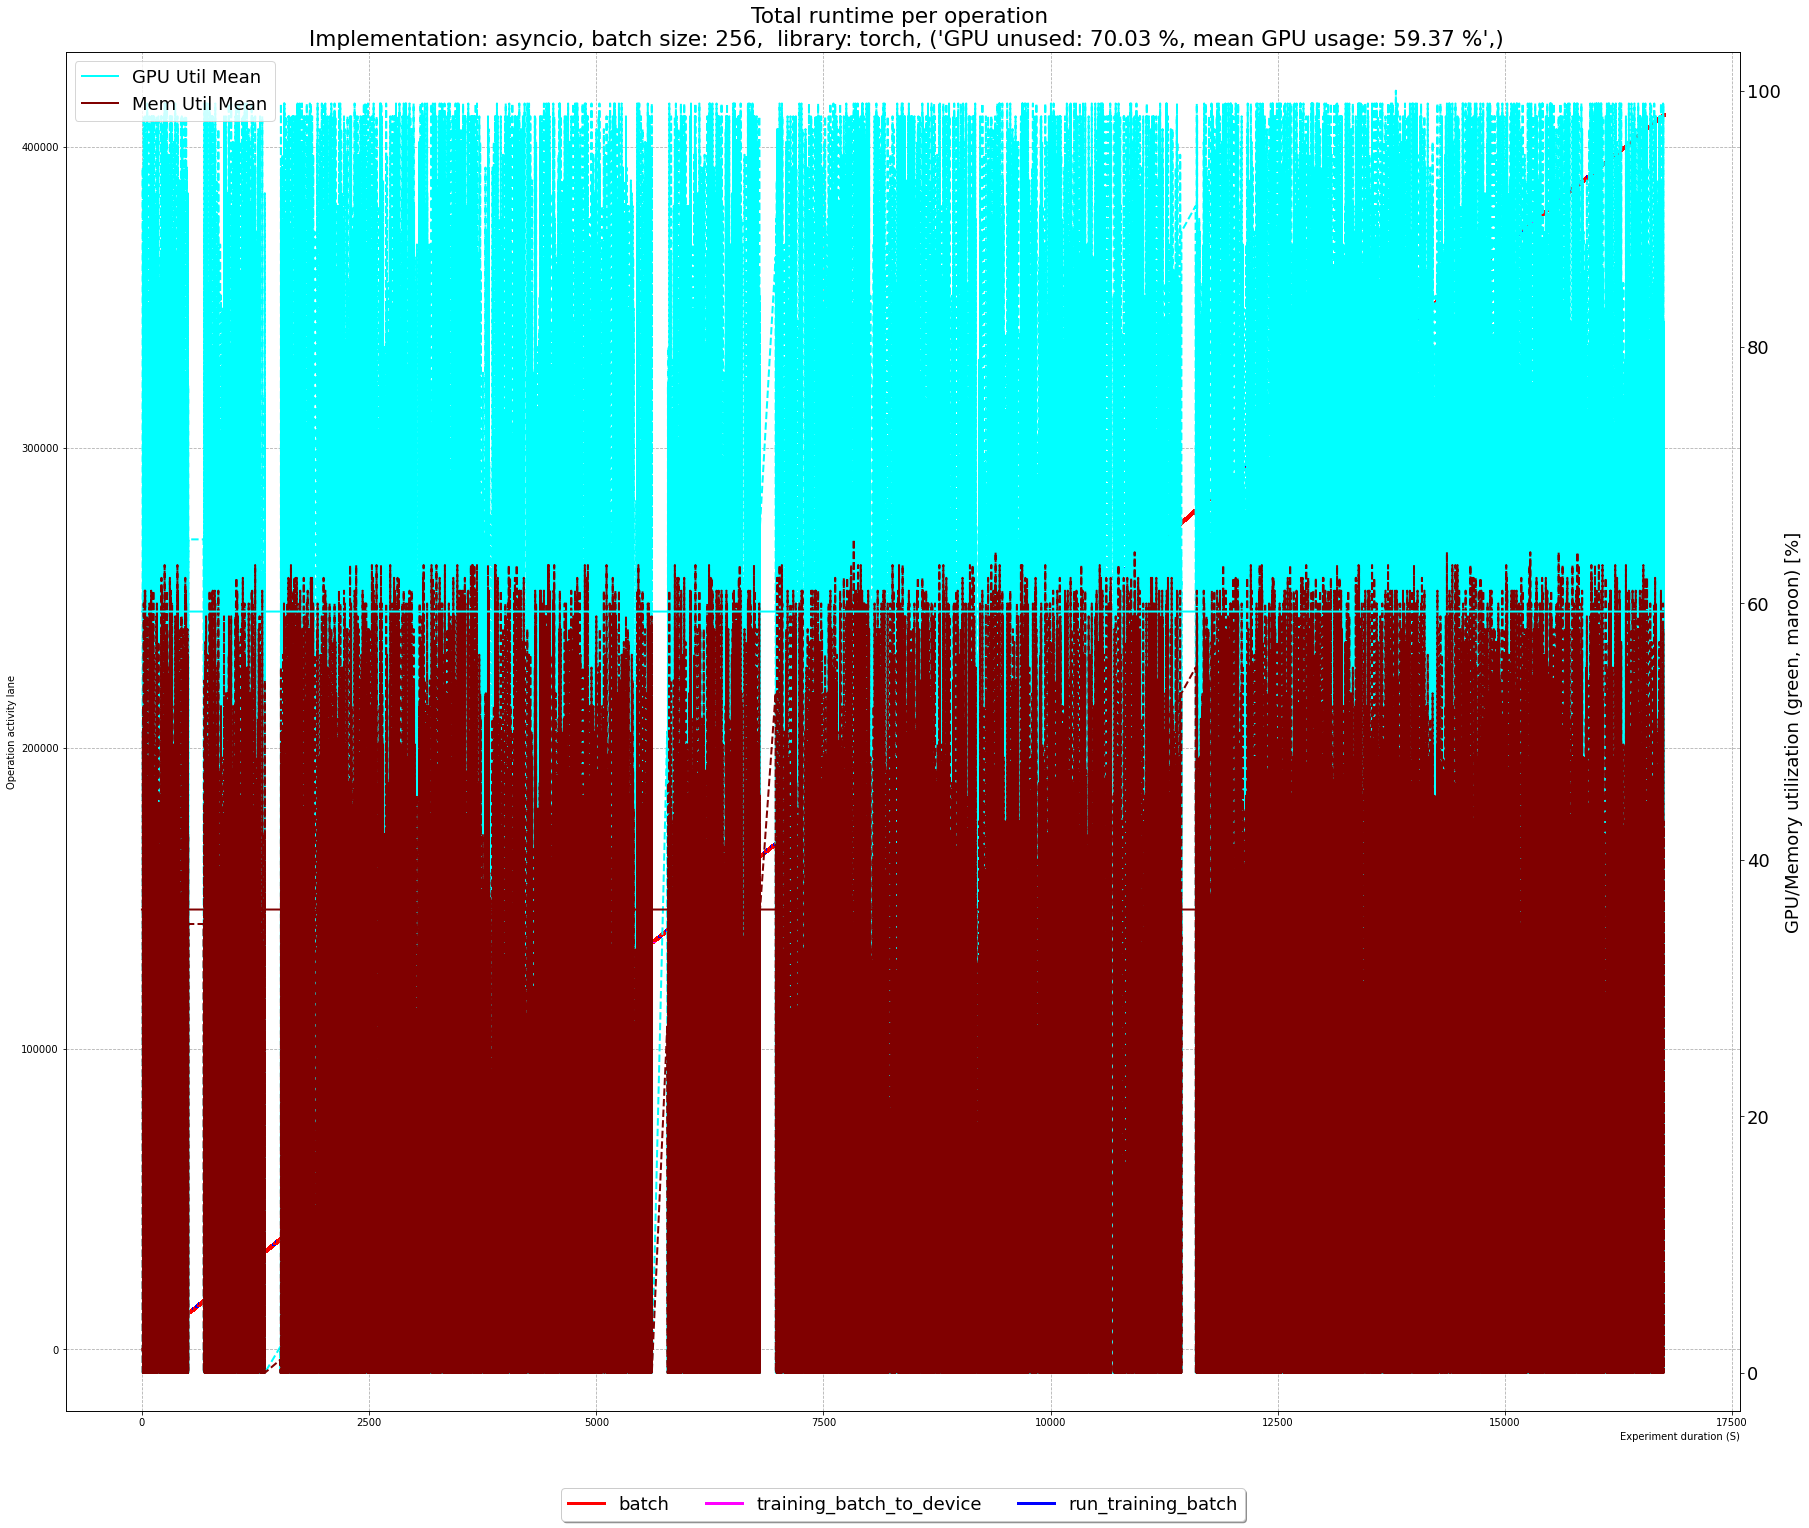

timestamp False
53.88104771438105 33.205855443732844


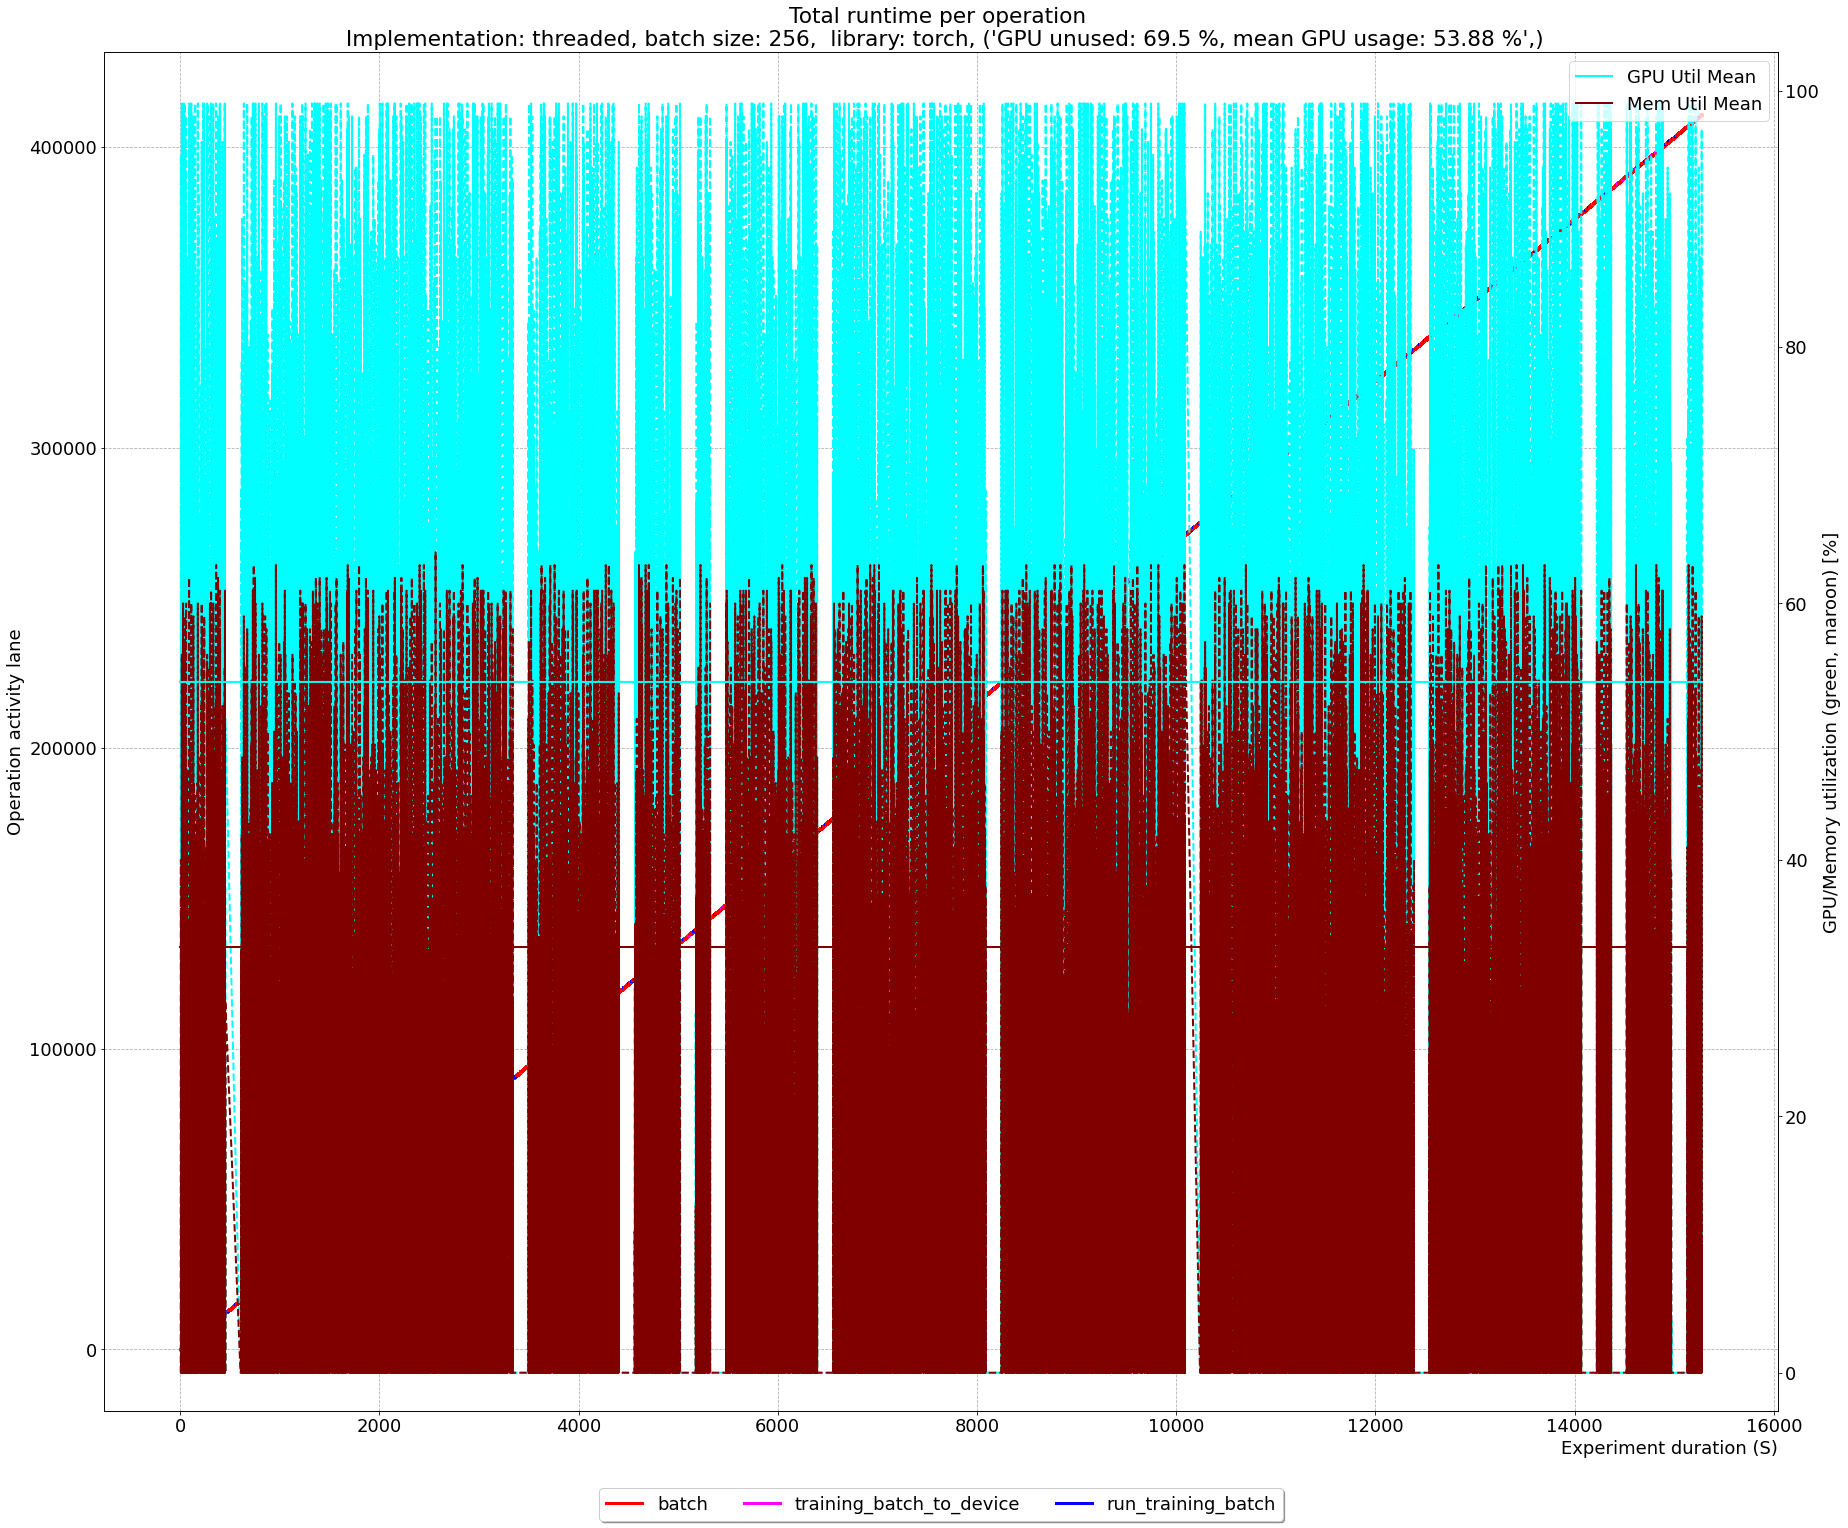

timestamp False
66.2442035029191 40.34270557029178


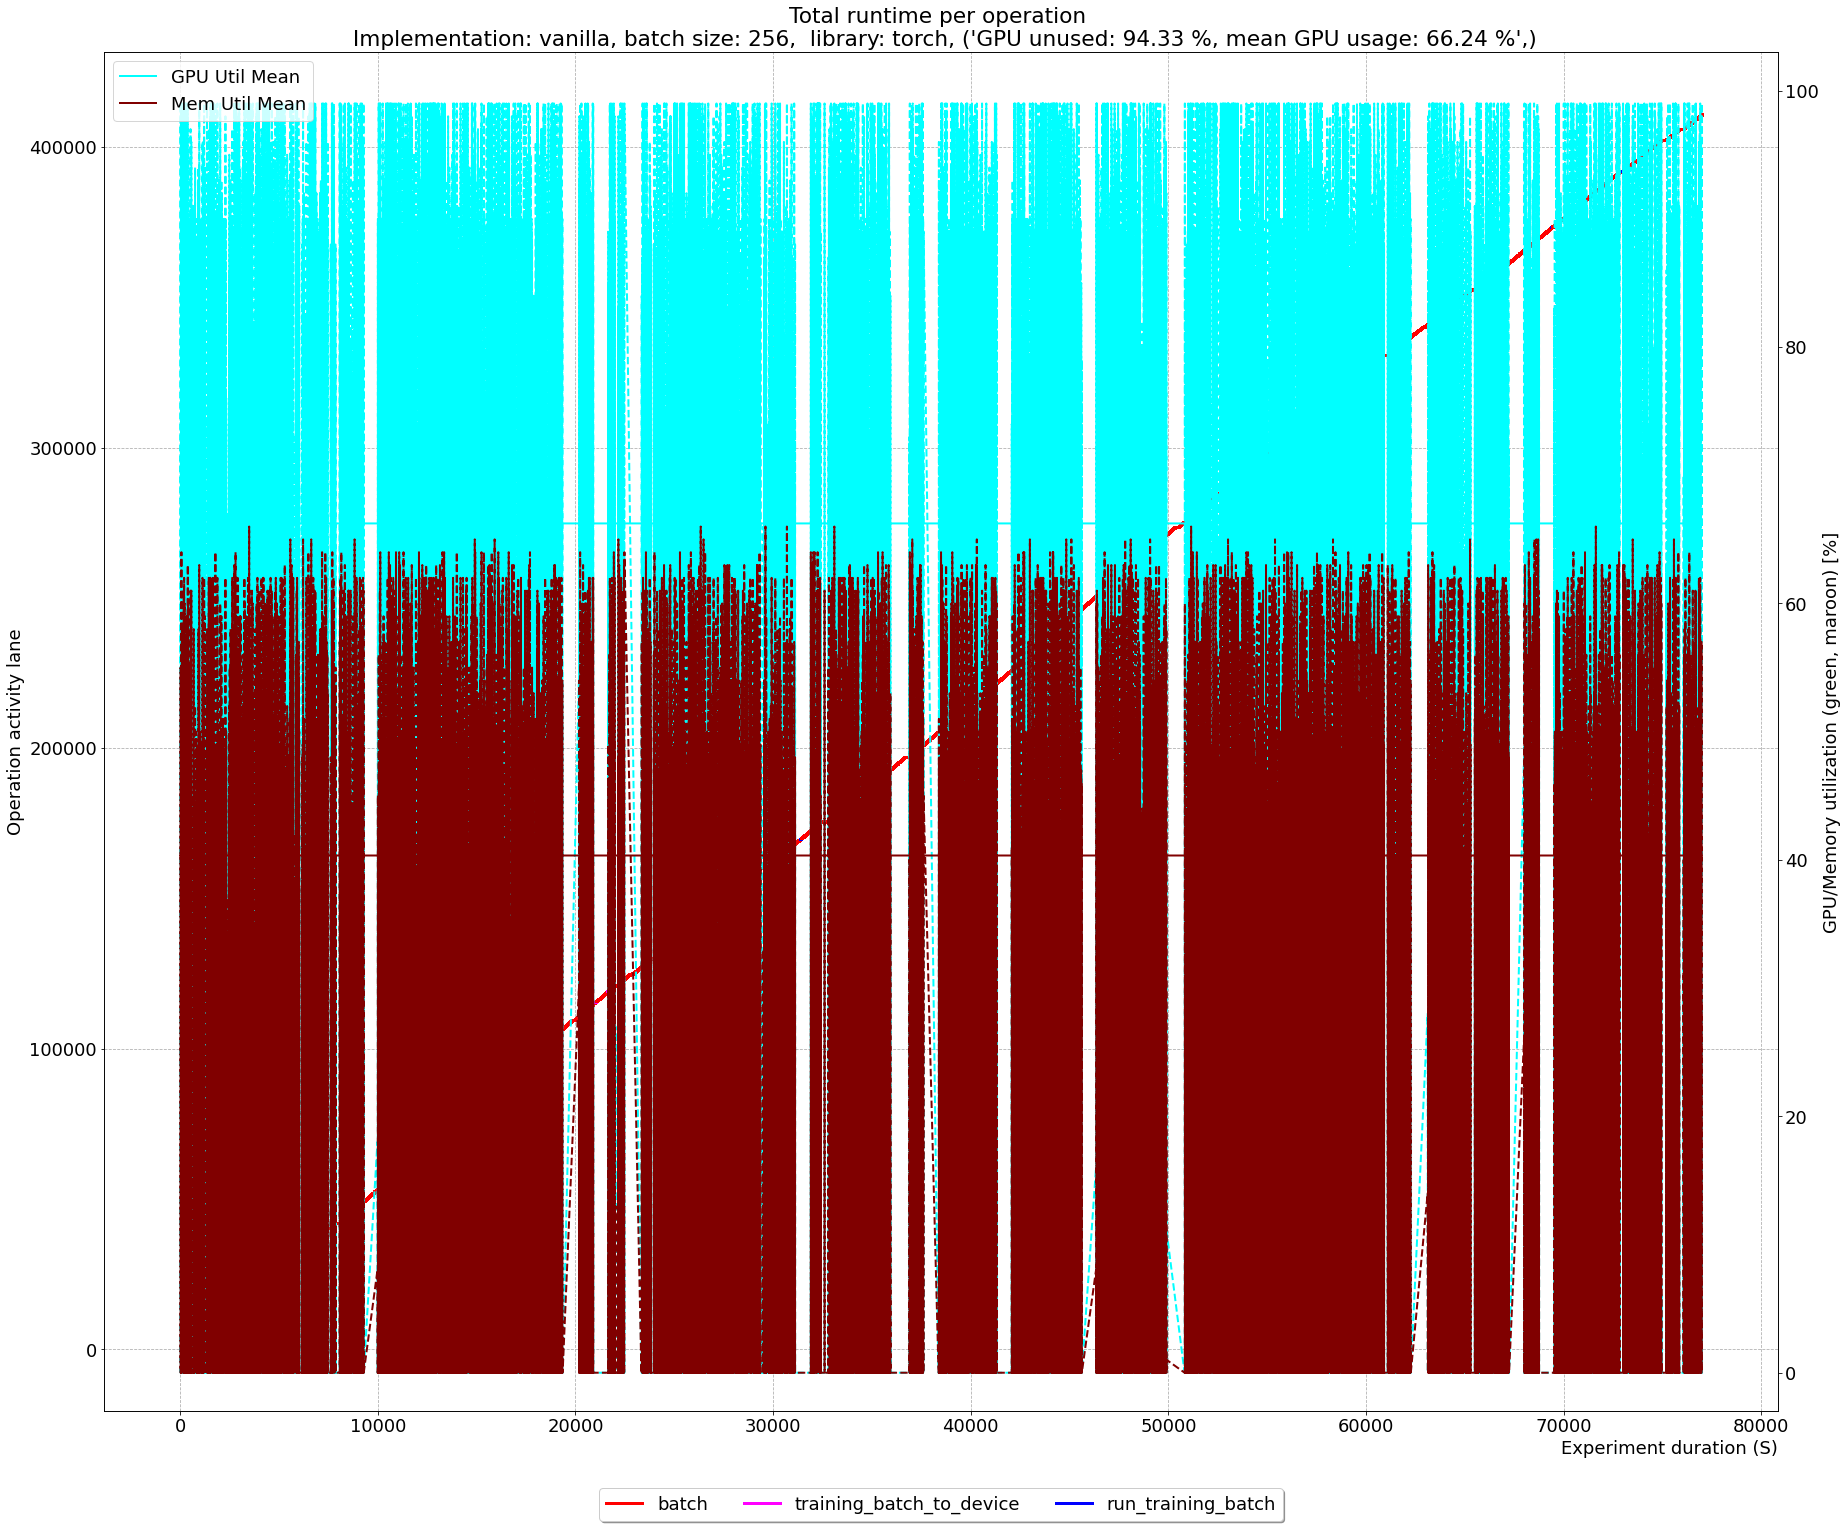

timestamp False
54.65152534768955 22.345026107912705


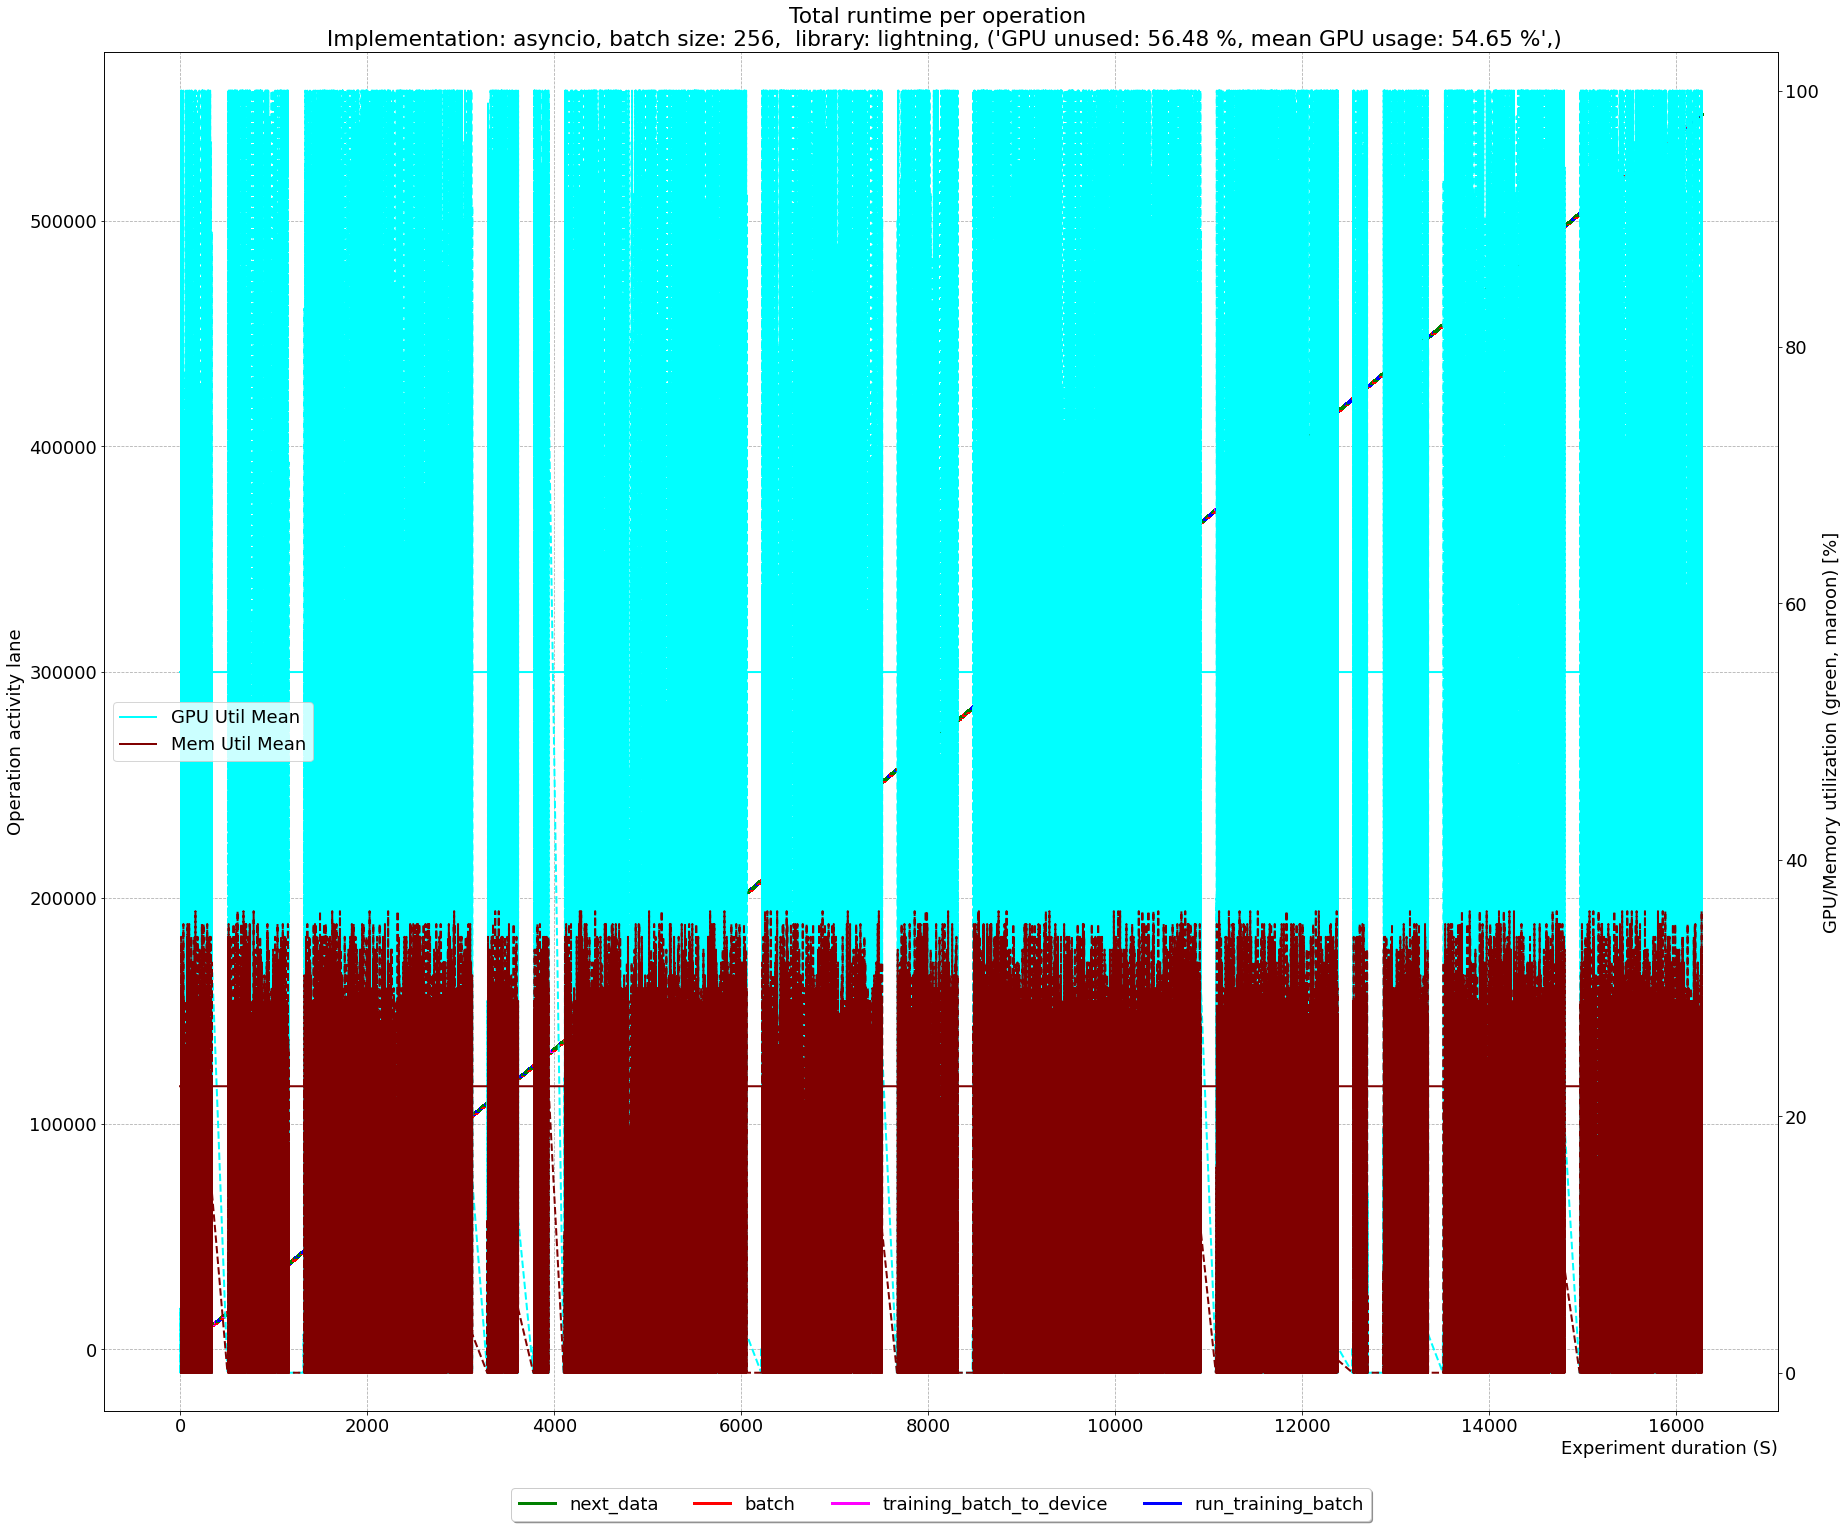

timestamp False
56.851581217057976 23.099536712059525


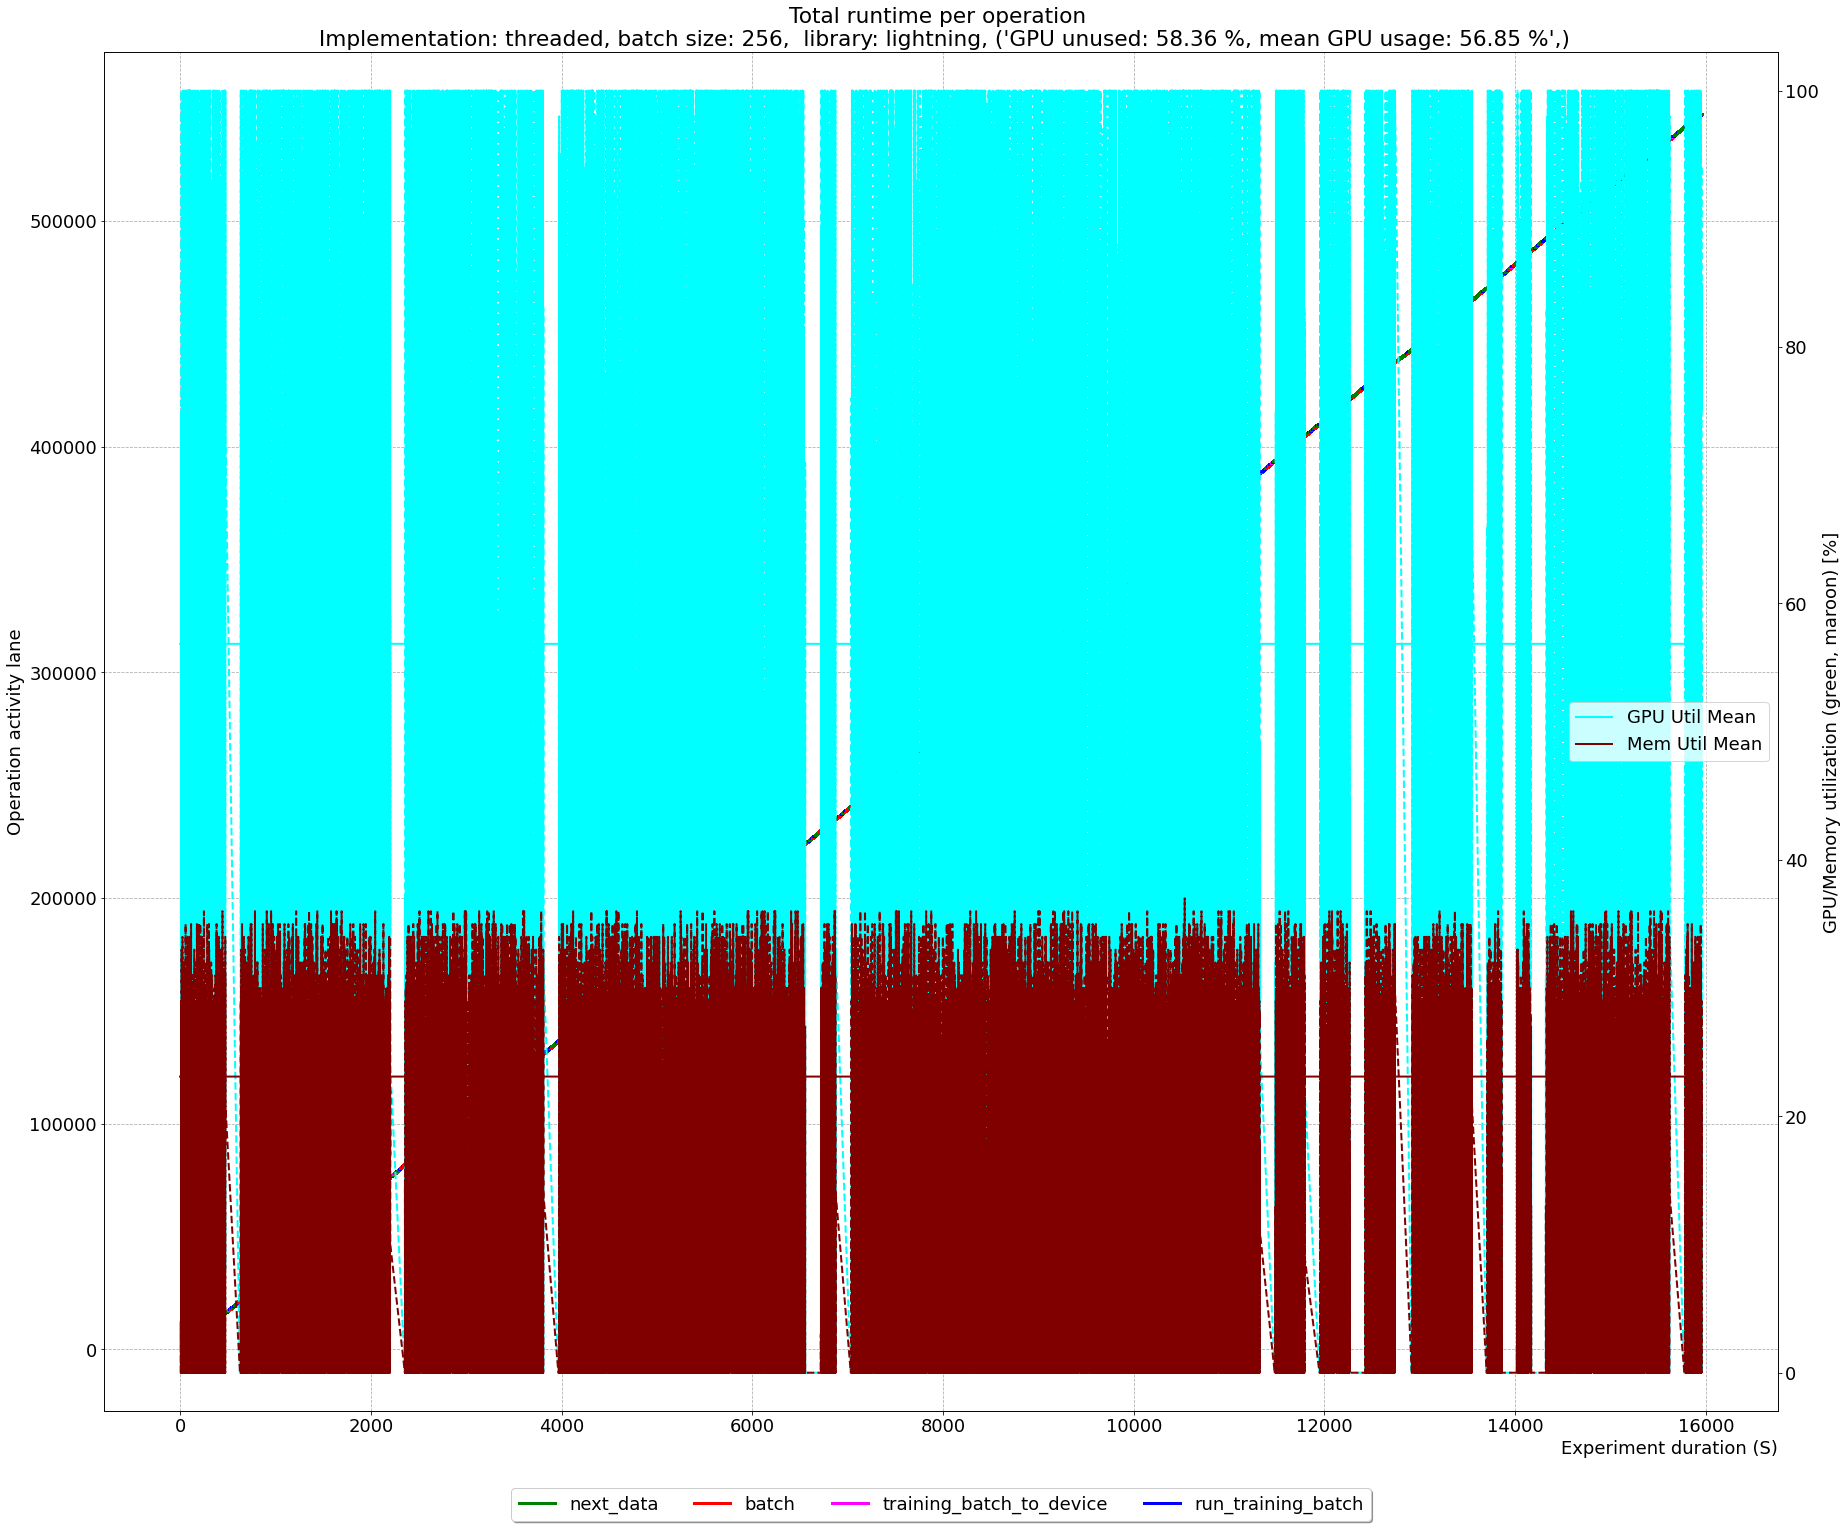

timestamp False
58.0409115377714 22.80971115022259


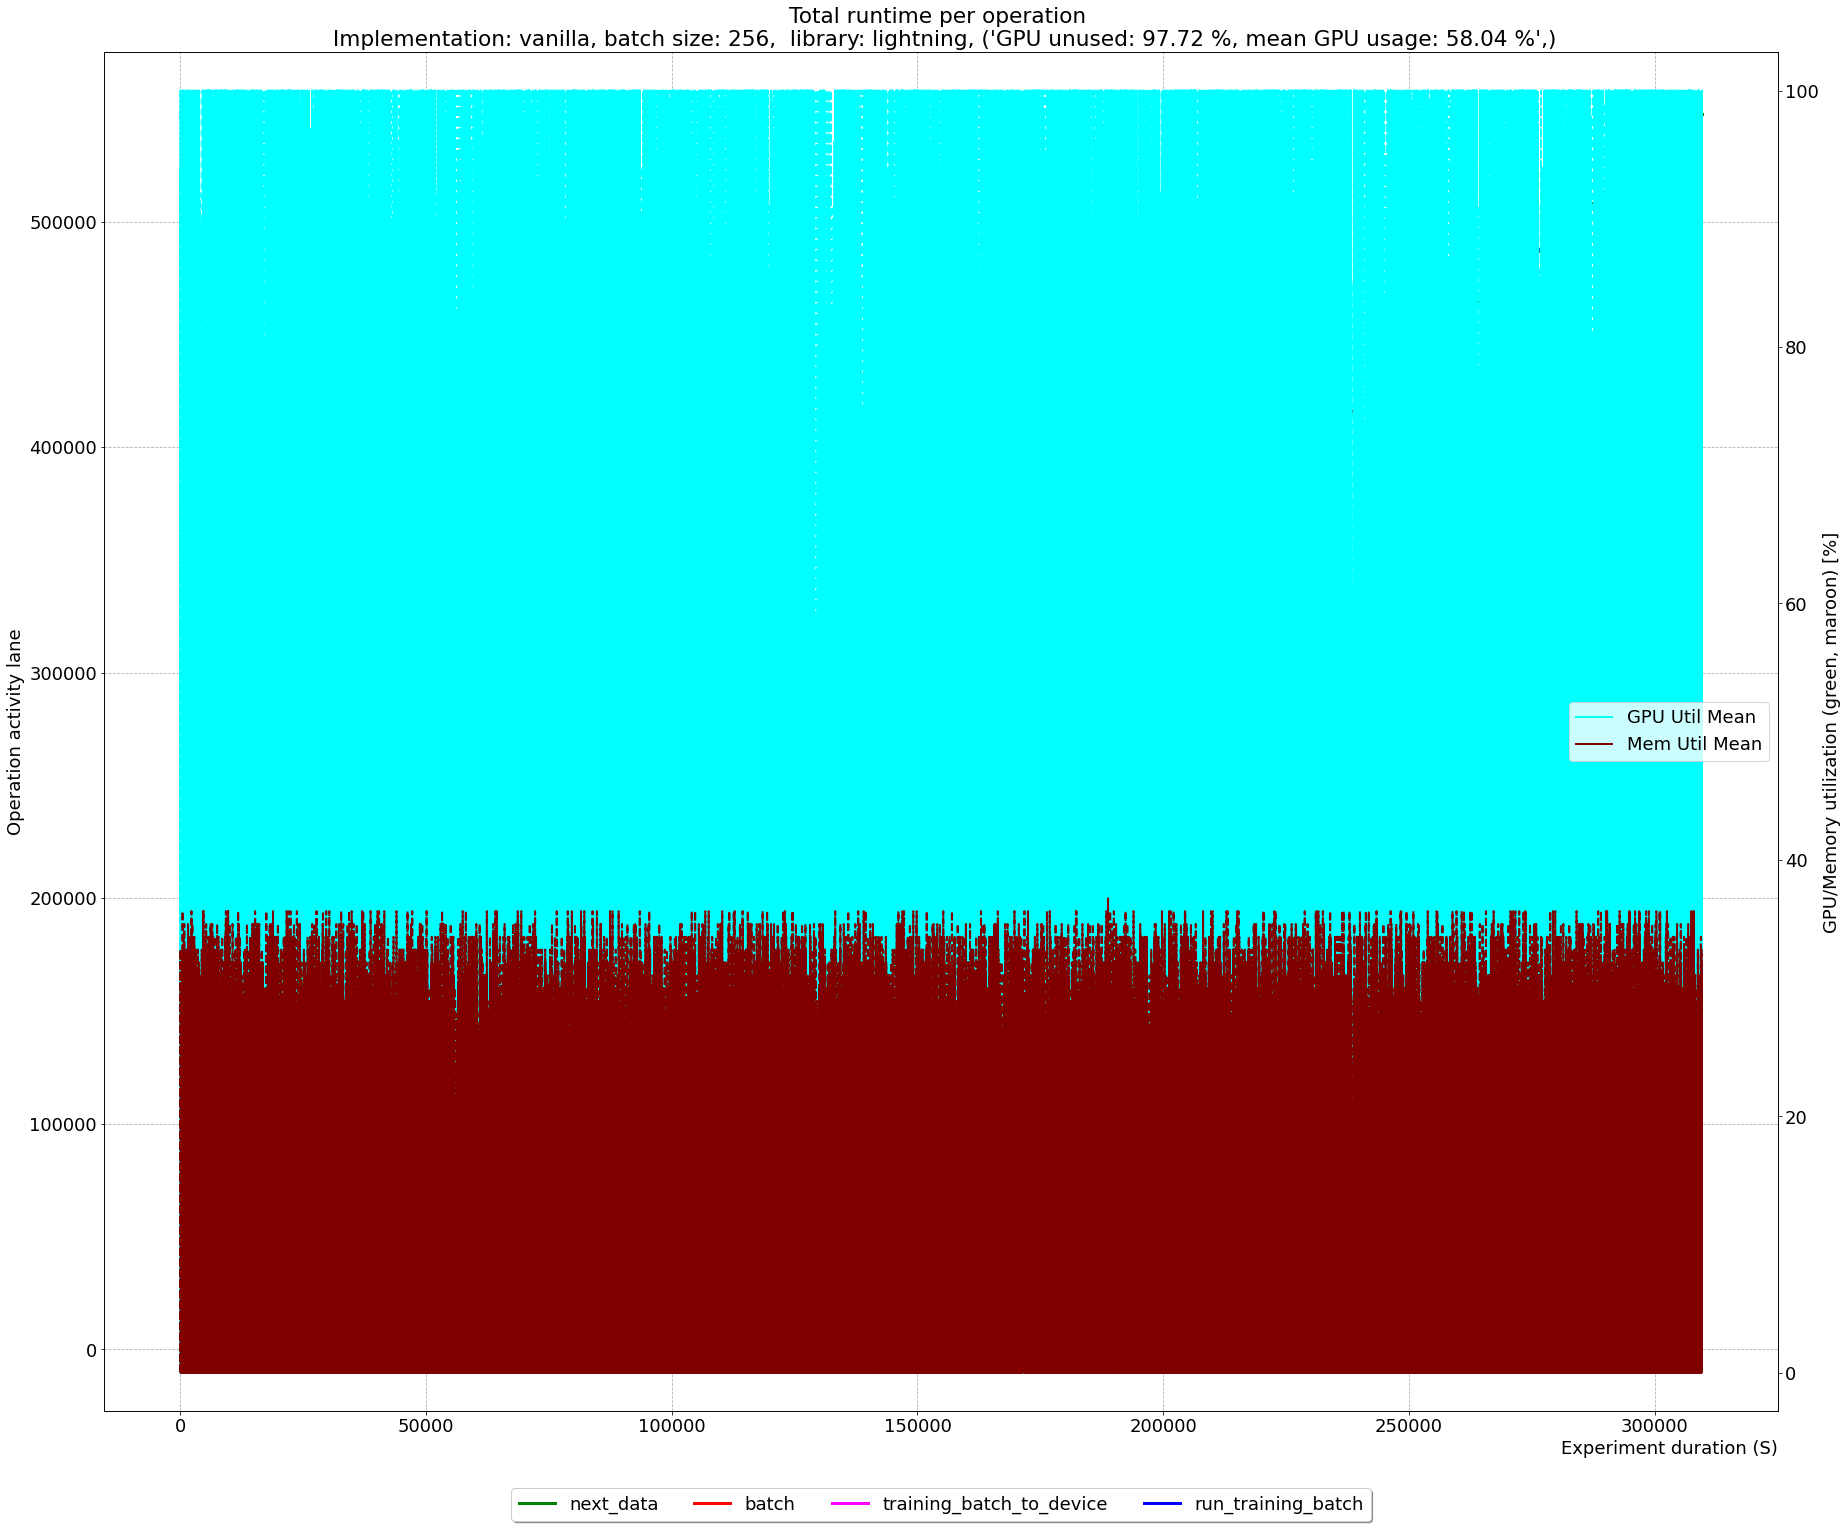

In [5]:
unique_runs_s3, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_s3)
returns_s3 = []

for implementation in ["torch", "lightning"]:
    for run in sorted(unique_runs_s3):
        if implementation in run:
            df = df_dataloader_s3[df_dataloader_s3["run"]==run]
            dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
            df = df.drop_duplicates(subset="id", keep="first", inplace=False) 
            result = show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, True, False, 2, gpu_index="0")
            result["run"]=run
            returns_s3.append(result)

In [12]:
unique_runs_s3 = np.unique(df_dataloader_s3["run"])
print(unique_runs_s3)

['20220118f224612_benchmark_e2e_torch_s3_256_4_16_0_asyncio_sync'
 '20220119f032522_benchmark_e2e_lightning_s3_256_4_16_0_asyncio_sync'
 '20220119f075644_benchmark_e2e_torch_s3_256_4_16_0_threaded_sync'
 '20220119f121123_benchmark_e2e_lightning_s3_256_4_16_0_threaded_sync'
 '20220119f163729_benchmark_e2e_torch_s3_256_4_16_0_vanilla_sync'
 '20220121f082622_benchmark_e2e_lightning_s3_256_4_16_0_vanilla_sync']


### Result tables

The following two tables display throughput details for both experiments. The default sample size, i.e. number of dataset items is 3000.

In [13]:
# sanity check
get_metadata_info(output_base_folder / "aws_long_1/" / unique_runs_s3[0])

Dataset:  35000
Batch size: 256
Epochs:  100
Images total:  3500000
Batches per epoch 137
Images total (rounded):  3507200


(35000, 256, 100, 3500000, 137, 3507200)

In [14]:
df_full_s3 = extract_pandas(output_base_folder, folder_filter=s3_folder_filter)
results_s3 = pd.DataFrame.from_records(data=returns_s3)
r = get_throughput(results_s3, "aws_long_1/", df_full_s3, unique_runs_s3, output_base_folder)
r

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [08:02<00:00,  4.37it/s]


,runtime,gpu_util_zero,gpu_util_mean_no_zeros,mem_util_mean,mem_util_mean_no_zeros,implementation,cache,library,throughput,dl_MB,imgs,Mbit/s,MB/s
0,16746.884438,70.033493,59.370966,9.745644,36.128767,asyncio,0,torch,208.994098,401557.013512,3500000,191.824104,23.978013
1,15276.229050,69.502391,53.881048,9.233235,33.205855,threaded,0,torch,215.083135,401557.013512,3500000,197.412895,24.676612
2,76987.910204,94.329951,66.244204,2.157721,40.342706,vanilla,0,torch,229.114135,298772.406006,3500000,156.463957,19.557995
3,16272.777470,56.479719,54.651525,8.146386,22.345026,asyncio,0,lightning,219.332502,298772.406006,3500000,149.783998,18.723000
4,15957.507309,58.357859,56.851581,8.207612,23.099537,threaded,0,lightning,45.461670,401556.872362,3499999,41.726746,5.215843
5,309552.717990,97.719540,58.040912,0.450770,22.809711,vanilla,0,lightning,11.306636,401557.013512,3500000,10.377735,1.297217


In [9]:
35000 / (16746.884438 / 100)

208.99409755633258

In [10]:
3500000 / 16746.884438

208.99409755633258

In [15]:
impls = ["threaded", "asyncio", "vanilla"]
libs = ["torch", "lightning"]

In [37]:
# since the experiment was not repeated, there is not array of values to plot in violin
# so here is a not-so-clever workaround 

df = pd.DataFrame()
def add_stats(row, metric):
    line = [row[metric]] * 3
    line.append(0.0)
    line.append(0.0)
    new_row = pd.DataFrame([pd.Series(line)], index = [row["implementation"] + "_" + row["library"]])
    return df.append(new_row)

# add to df
for index, row in results_s3.iterrows():
    df = add_stats(row, "throughput")

# give names
df.columns = [0, 1, "mean", "std_dev", "var"]

In [38]:
df

,0,1,mean,std_dev,var
asyncio_torch,208.994098,208.994098,208.994098,0.0,0.0
threaded_torch,215.083135,215.083135,215.083135,0.0,0.0
vanilla_torch,229.114135,229.114135,229.114135,0.0,0.0
asyncio_lightning,219.332502,219.332502,219.332502,0.0,0.0
threaded_lightning,45.461670,45.461670,45.461670,0.0,0.0
vanilla_lightning,11.306636,11.306636,11.306636,0.0,0.0


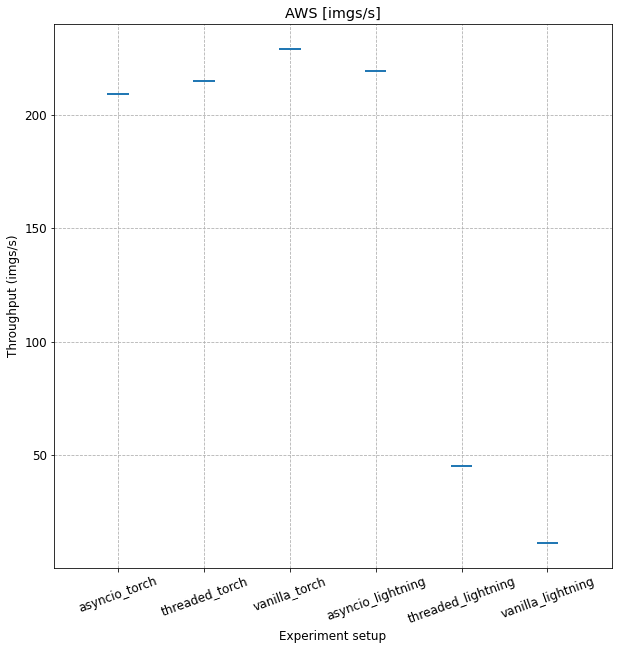

In [39]:
plot_violins(df, "AWS [imgs/s]") # 

In [33]:
# add to df
df = pd.DataFrame()
for index, row in results_s3.iterrows():
    df = add_stats(row, "Mbit/s")

# # give names
df.columns = [0, 1, "mean", "std_dev", "var"]

In [34]:
df

,0,1,mean,std_dev,var
asyncio_torch,191.824104,191.824104,191.824104,0.0,0.0
threaded_torch,197.412895,197.412895,197.412895,0.0,0.0
vanilla_torch,156.463957,156.463957,156.463957,0.0,0.0
asyncio_lightning,149.783998,149.783998,149.783998,0.0,0.0
threaded_lightning,41.726746,41.726746,41.726746,0.0,0.0
vanilla_lightning,10.377735,10.377735,10.377735,0.0,0.0


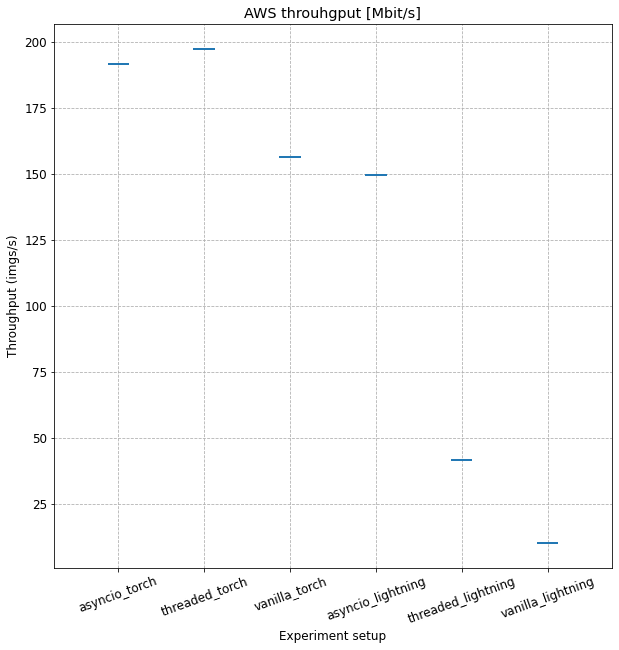

In [36]:
plot_violins(df, "AWS throuhgput [Mbit/s]") # 